In [362]:
import pandas as pd 
import matplotlib.pyplot as plt 
import numpy as np 
from astropy.io.votable import parse
from astropy.coordinates import SkyCoord
from astropy import units as u 
from sunpy.coordinates import frames
from sunpy.time import parse_time
import datetime
from dateutil.relativedelta import relativedelta
import warnings
warnings.filterwarnings("ignore")

This data is being pulled from HELIO https://www.helio-vo.eu/ from the `gevloc_sxr_flare` table

In [5]:
aa = parse("http://hec.helio-vo.eu/hec/hec_gui_fetch.php?interfacetype=vmstilts&sql=select+%2A+from+gevloc_sxr_flare+where+time_start%3E%3D%272010-01-01+00%3A00%3A00%27+AND+time_start%3C%3D%272018-12-31+23%3A59%3A59%27&type=votable")

In [27]:
full_table = aa.get_first_table().to_table().to_pandas()
full_table.head()


,time_start,time_end,time_peak,xray_class,lat_hg,long_hg,long_carr,nar,ename,url_nar,url_flare
0,2010-01-01 12:02:00.0,2010-01-01 12:18:00.0,2010-01-01 12:09:00.0,B1.9,-29,31,57.28,11039,gev_20100101_1202,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...
1,2010-01-01 12:33:00.0,2010-01-01 13:00:00.0,2010-01-01 12:43:00.0,B2.3,-24,34,60.00,11039,gev_20100101_1233,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...
2,2010-01-01 23:29:00.0,2010-01-01 23:42:00.0,2010-01-01 23:33:00.0,B1.1,-25,39,59.00,11039,gev_20100101_2329,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...
3,2010-01-02 03:10:00.0,2010-01-02 03:19:00.0,2010-01-02 03:13:00.0,B1.1,-26,39,56.98,11039,gev_20100102_0310,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...
4,2010-01-02 07:09:00.0,2010-01-02 07:40:00.0,2010-01-02 07:24:00.0,C1.0,-26,41,56.79,11039,gev_20100102_0709,http://www.solarmonitor.org/region.php?date=20...,http://www.lmsal.com/solarsoft/latest_events_a...


In [28]:
full_table["goes_class_ind"] = [x[0] for x in full_table["xray_class"]]

In [65]:
def get_goes_class(x):
    if x[0]=="C":
        return float(x[1:])*1e-6
    elif x[0] == "M":
        return float(x[1:])*(1e-5)
    elif x[0] == "X":
        return float(x[1:])*(1e-4)
    else:
        return

In [66]:
full_table["goes_class_val"] = full_table["xray_class"].map(get_goes_class)

In [67]:
full_table.to_csv("full_sswlatest.csv", index_label=False)

## Lets inspect data
Lets just focus on X, M, and C class flares

In [301]:
full_table_c = full_table[full_table["goes_class_ind"].isin(["X", "M", "C"])]

In [302]:
full_table_c.reset_index(inplace=True, drop=True)

In [303]:
full_table_c = full_table_c.fillna(-9999)

In [306]:
full_table_c.drop(full_table_c[(full_table_c["long_hg"] == 0) & (full_table_c["lat_hg"] == 0)].index, inplace=True)
full_table_c.drop(full_table_c[full_table_c.lat_hg<-60].index, inplace=True)
# full_table_c.drop(full_table_c[(full_table_c.nar==1000) | 
#                                (full_table_c.nar==-9999) | 
#                                (full_table_c.nar==0)].index, inplace=True)

In [307]:
print("X: {:d}, M: {:d}, C: {:d}".format(np.sum(full_table_c["goes_class_ind"].isin(["X"])), 
                                         np.sum(full_table_c["goes_class_ind"].isin(["M"])),
                                         np.sum(full_table_c["goes_class_ind"].isin(["C"]))))

X: 49, M: 726, C: 7941


In [308]:
coords_hgs = SkyCoord(full_table_c["long_hg"]*u.deg, full_table_c["lat_hg"]*u.deg,
                  frame=frames.HeliographicStonyhurst, observer="earth", obstime=pd.to_datetime(full_table_c["time_start"]))

In [309]:
coords_hpc = coords_hgs.transform_to(frames.Helioprojective(observer="earth"))

In [317]:
full_table_c["hpc_x"], full_table_c["hpc_y"] = coords_hpc.Tx.value, coords_hpc.Ty.value

In [349]:
full_table_c["time_start_datetime"] = pd.to_datetime(full_table_c["time_start"])
full_table_c["time_peak_datetime"] = pd.to_datetime(full_table_c["time_peak"])

In [350]:
full_table_c["tt"] = np.array([d.total_seconds() for d in full_table_c["time_start_datetime"] - full_table_c["time_start_datetime"].iloc[0]])/60/60

In [351]:
full_table_c["unique_day"] = full_table_c.time_start_datetime.dt.strftime("%Y-%m-%d")

In [355]:
len(full_table_c["unique_day"].unique())

1677

In [404]:
full_table_c["unique_day2"] = pd.to_datetime(full_table_c["unique_day"]) 

<AxesSubplot:xlabel='unique_day2'>

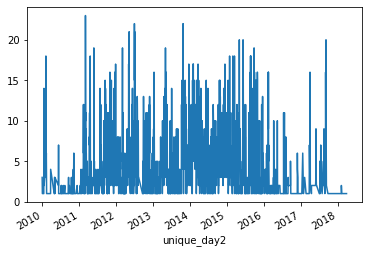

In [408]:
full_table_c.groupby("unique_day2")["goes_class_ind"].count().plot()

In [421]:
full_table_c_test = full_table_c[(full_table_c["nar"]!=-9999)&(full_table_c["nar"]!=0)&(full_table_c["nar"]!=10000)]

In [512]:
full_table_c_test["nar"] = full_table_c_test["nar"].astype("str")

In [514]:
%matplotlib inline
full_table_c_test.groupby("nar")["goes_class_ind"].count()

nar
11039     5
11040     2
11041    22
11045    23
11046     4
         ..
12680     2
12683     3
12685     1
12699     7
12700     1
Name: goes_class_ind, Length: 864, dtype: int64

<IPython.core.display.Javascript object>


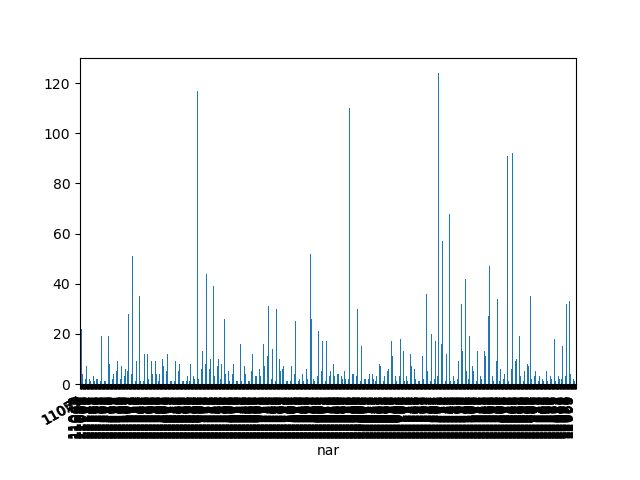

<AxesSubplot:xlabel='unique_day2'>

In [506]:
full_table_c_test.groupby("unique_day2")["goes_class_ind"].count().plot()

In [508]:
full_table_c.time_peak_datetime.dt.day_of_year

0        2
1        2
2        2
3        3
4        4
        ..
8768    41
8769    42
8770    43
8771    61
8772    89
Name: time_peak_datetime, Length: 8716, dtype: int64

## get unique days

In [379]:
# Pull out start and end times
tstart = parse_time("2010-01-01").datetime
tfinal = parse_time("2018-03-31").datetime
# create list and loop over to make unique list of days
time_over = [tstart.strftime('%Y-%m-%d')]
t0 = tstart
while t0 < tfinal:
    t0 = t0 + relativedelta(days=1)
    time_over.append(t0.strftime('%Y-%m-%d'))

In [384]:
no_flares = []
for t in time_over:
    no_flares.append(np.sum(full_table_c["unique_day"].isin([t])))

In [447]:
np.argmax(no_flares)

429

<IPython.core.display.Javascript object>


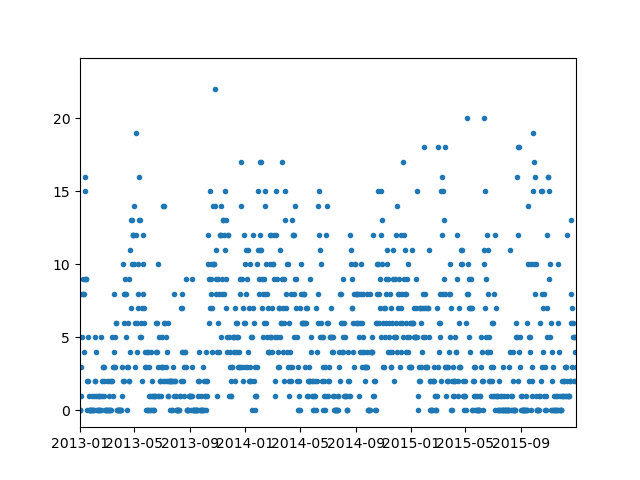

(15706.0, 16800.0)

In [471]:
plt.plot(pd.to_datetime(time_over), no_flares, marker='.',ls="")
plt.xlim(parse_time("2013-01-01").datetime, parse_time("2015-12-31").datetime)

In [452]:
time_over

['2010-01-01',
 '2010-01-02',
 '2010-01-03',
 '2010-01-04',
 '2010-01-05',
 '2010-01-06',
 '2010-01-07',
 '2010-01-08',
 '2010-01-09',
 '2010-01-10',
 '2010-01-11',
 '2010-01-12',
 '2010-01-13',
 '2010-01-14',
 '2010-01-15',
 '2010-01-16',
 '2010-01-17',
 '2010-01-18',
 '2010-01-19',
 '2010-01-20',
 '2010-01-21',
 '2010-01-22',
 '2010-01-23',
 '2010-01-24',
 '2010-01-25',
 '2010-01-26',
 '2010-01-27',
 '2010-01-28',
 '2010-01-29',
 '2010-01-30',
 '2010-01-31',
 '2010-02-01',
 '2010-02-02',
 '2010-02-03',
 '2010-02-04',
 '2010-02-05',
 '2010-02-06',
 '2010-02-07',
 '2010-02-08',
 '2010-02-09',
 '2010-02-10',
 '2010-02-11',
 '2010-02-12',
 '2010-02-13',
 '2010-02-14',
 '2010-02-15',
 '2010-02-16',
 '2010-02-17',
 '2010-02-18',
 '2010-02-19',
 '2010-02-20',
 '2010-02-21',
 '2010-02-22',
 '2010-02-23',
 '2010-02-24',
 '2010-02-25',
 '2010-02-26',
 '2010-02-27',
 '2010-02-28',
 '2010-03-01',
 '2010-03-02',
 '2010-03-03',
 '2010-03-04',
 '2010-03-05',
 '2010-03-06',
 '2010-03-07',
 '2010-03-

In [502]:
test_df = full_table_c[(full_table_c["time_start_datetime"]>"2013-01-01") & \
                        (full_table_c["time_start_datetime"]<"2015-01-01")]

time_over[1096]

'2013-01-01'

In [503]:
time_over2 = time_over[1096:]

In [504]:
import matplotlib.animation as animation

def animate(i):
    data = test_df[test_df["unique_day"].isin([time_over2[i]])]
    
#     fig, ax = plt.subplots()

    circle1 = plt.Circle((0, 0), 960, color='k', fill=False)  
    ax.add_artist(circle1)
    ax.set_xlim(-1100, 1100)
    ax.set_ylim(-1100, 1100)
    ax.set_aspect('equal')
    if len(data)>0:
        ax.scatter(data["hpc_x"], data["hpc_y"], alpha=0.4, 
                   s=data["goes_class_val"]*1e7)
    

<IPython.core.display.Javascript object>


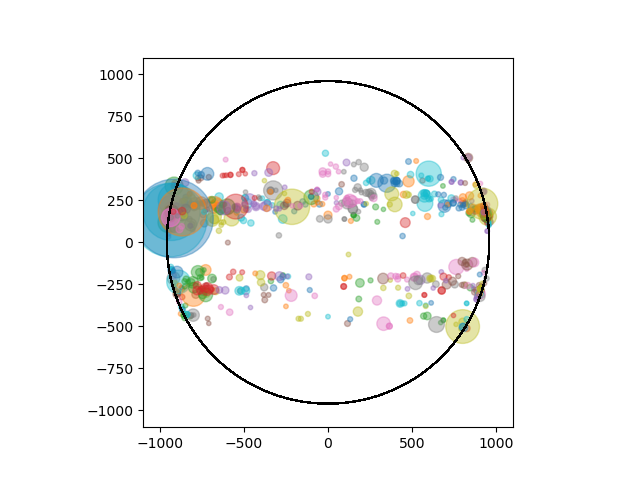

In [505]:
%matplotlib notebook
fig = plt.figure()
#creating a subplot 
ax = fig.add_subplot(1,1,1)
ani = animation.FuncAnimation(fig, animate, interval=500) 

In [461]:
ani = animation.FuncAnimation(fig, animate, interval=1000) 

NameError: name 'ax' is not defined

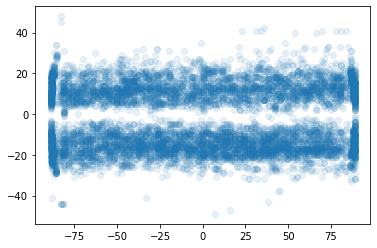

In [429]:
plt.scatter(coords_hgs.lon, coords_hgs.lat, alpha=0.1)

In [332]:
testy = full_table_c

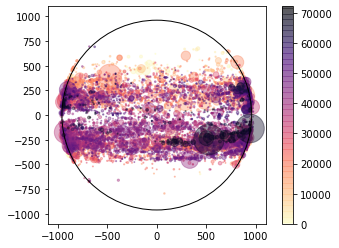

In [343]:
plt.scatter(testy["hpc_x"], testy["hpc_y"], alpha=0.4, s=testy["goes_class_val"]*1e6,
            c=full_table_c["tt"]/60/60, cmap="magma_r")
plt.axes().set_aspect('equal')
circle1 = plt.Circle((0, 0), 960, color='k', fill=False)
plt.gca().add_artist(circle1)
plt.xlim(-1100, 1100)
plt.ylim(-1100, 1100)
plt.colorbar()

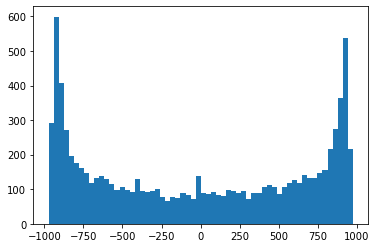

In [313]:
_ = plt.hist(coords_hpc.Tx.value, bins=60)

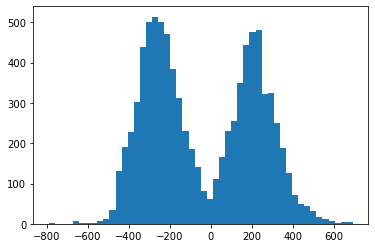

In [314]:
_ = plt.hist(coords_hpc.Ty.value, bins=50)

In [315]:
len(full_table_c)

8716

In [515]:
ar_data = pd.read_csv('/Users/laurahayes/spaceweather_stuff/SolarStatsStuff/ar_analysis/all_ar_2010-2020.csv')

In [518]:
len(ar_data["ar_noaanum"].unique())

1725

In [519]:
len(full_table_c["nar"].unique())

867